# 用支援向量機(SVM)和主成份分析(PCA)作人臉辨識

In [1]:
# Labeled Face in the Wild: http://vis-www.cs.umass.edu/lfw/
# http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=100)
#(data_home=None, funneled=True, resize=0.5, min_faces_per_person=40, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)
#(data_home=None, funneled=True, resize=0.5, min_faces_per_person=40, color=False, slice_=(slice(70, 195, None), slice(78, 172, None))
print(faces.target_names)
import warnings
warnings.filterwarnings('ignore')

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


In [2]:
faces.images.shape # 每個圖像包含 62*47 = 2914 像素點

(1140, 62, 47)

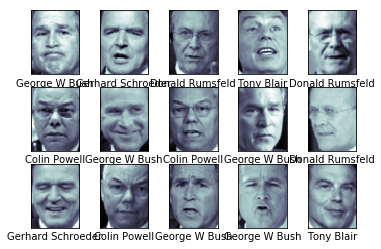

In [3]:
# 畫出人臉看資料內容
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap="bone")
    axi.set(xticks=[], yticks=[],
    xlabel=faces.target_names[faces.target[i]])

In [4]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#主成份分析萃取150個基礎成分，並把它們匯入到支援向量機分類器中
pca = PCA(n_components=150, random_state=42)
svc = SVC(kernel="rbf",class_weight="balanced")
model = Pipeline(steps=[('pca',pca), ('svm',svc)])

In [5]:
# 把資料集分成訓練集和測試集，test size 預設是0.25
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42) 

In [6]:
# 訓練模型
%time model.fit(Xtrain, ytrain)

Wall time: 257 ms


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [7]:
yfit = model.predict(Xtest) # 預測沒見過的測試資料標籤

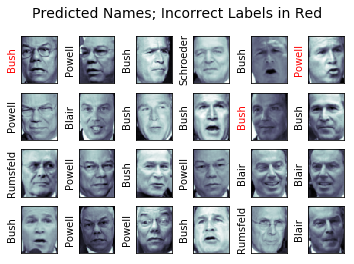

In [8]:
# 檢視影像和被預測的標籤值
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62,47), cmap="bone")
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1], 
                   color="black" if yfit[i] == ytest[i] else 'red')
    fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
    

In [9]:
# 評估分類器效能
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.81      0.88      0.84        64
  Donald Rumsfeld       0.89      0.78      0.83        32
    George W Bush       0.85      0.89      0.87       127
Gerhard Schroeder       0.77      0.59      0.67        29
       Tony Blair       0.82      0.82      0.82        33

         accuracy                           0.84       285
        macro avg       0.83      0.79      0.81       285
     weighted avg       0.83      0.84      0.83       285



Text(91.68, 0.5, 'predicted label')

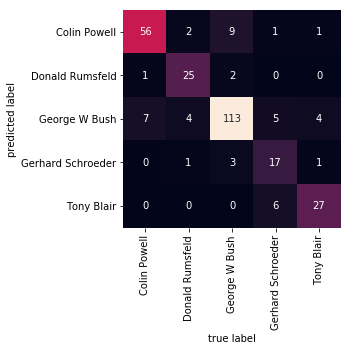

In [10]:
# 混淆矩陣 (confusion matrix)
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=faces.target_names,
           yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

# 利用主成份分析(PCA)找特徵臉

In [11]:
from sklearn.decomposition import PCA
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

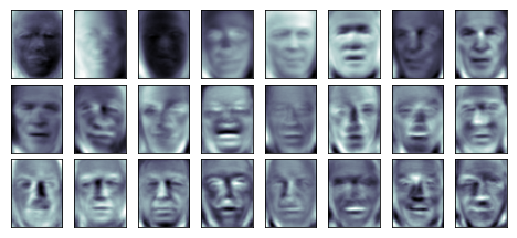

In [12]:
# 找到的主成份 特徵向量(eignevectors)，視覺化的影像通常稱為 特徵臉
fig, axes = plt.subplots(3, 8, figsize=(9,4),
                        subplot_kw = {'xticks':[], 'yticks':[]},
                        gridspec_kw= dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Text(0, 0.5, 'cumulative explained variance')

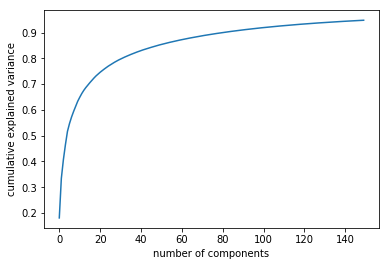

In [13]:
# 檢視特徵向量的累積變異量，看降維投影中多少資訊被保留
import numpy as np

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0, 0.5, '150-dim\ninput')

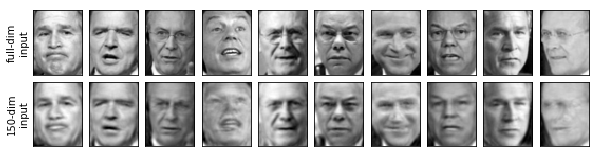

In [14]:
#利用150維度PCA重建影像

# 計算成份和被投射的臉
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

# 繪圖
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw = {'xticks':[], 'yticks':[]},
                       gridspec_kw = dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62,47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62,47), cmap='binary_r')

ax[0, 0].set_ylabel("full-dim\ninput")
ax[1, 0].set_ylabel("150-dim\ninput")